In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re
import copy
import collections

we will be using networkx package http://networkx.readthedocs.io/en/networkx-1.11/index.html

### Load enron dataset into pandas
Link to Enron company https://en.wikipedia.org/wiki/Enron. You can find the data [here](https://drive.google.com/file/d/1R8TW3CUN5UM_EtQT923EtyCmICPX2NZ8/view?usp=sharing).

# Data cleaning and preparation

In [17]:
# we are using = as a separator so we don't mix text with columns separator
df_enron = pd.read_csv("enron.csv", sep="=")
df_enron.drop('Unnamed: 0',axis = 1, inplace = True)

In [18]:
df_enron

,from,to,date,text,day_of_week
0,shelley.corman@enron.com,"jean.adams@enron.com, william.aldinger@enron.c...",20 Nov 2001 15,Please Send to ETS Gas Logistics Staff (Exclud...,Tue
1,frank.ermis@enron.com,mike.grigsby@enron.com,14 Feb 2001 02,no,Wed
2,joan.veselack@enron.com,"jwhited@columbiaenergygroup.com, chris.germany...",22 Mar 2000 08,Per my voicemail message to John.I talked to S...,Wed
3,sharon.crawford@enron.com,"chris.gaffney@enron.com, mark.powell@enron.com...",27 Oct 2000 04,Attached is Stikeman Elliott's derivatives upd...,Fri
4,chris.germany@enron.com,"victor.lamadrid@enron.com, edward.terry@enron....",25 Sep 2000 05,FOM New Power numbers.---------------------- F...,Mon
...,...,...,...,...,...
34019,david.delainey@enron.com,robert.virgo@enron.com,9 Feb 2001 10,"Bob, please give me an update on our progress ...",Fri
34020,james.centilli@enron.com,tracy.geaccone@enron.com,17 Oct 2001 07,"The project can not be justified, if you have ...",Wed
34021,charles.weldon@enron.com,"bryan.hull@enron.com, a..martin@enron.com, joe...",12 Sep 2001 10,"-----Original Message-----From: \tSchlueter, ...",Wed
34022,vince.kaminski@enron.com,toni.graham@enron.com,9 Oct 2000 04,"Toni,FYI.Vince---------------------- Forwarded...",Mon


In [19]:
len(df_enron['from'].unique())

3219

## Task
Take only part of email address until the @ (not important for analysis) and add a column with link (concatenation of sender and receiver).

In [20]:
df = copy.deepcopy(df_enron)

In [21]:
df['from'] = pd.Series(df['from'].str.split("@", expand= True)[0])

In [22]:
#len(df['to'][0].split(','))

In [23]:
df['to'] = df['to'].str.replace('\n', '')
df['to'] = df['to'].str.replace('\t', '')
df['to'] = df['to'].str.split(',')

In [24]:
df = df.explode('to')
df['to'] = pd.Series(df['to'].str.split("@", expand= True)[0])

In [25]:
df['link'] = df['from'] + ','+ df['to']

In [26]:
df

,from,to,date,text,day_of_week,link
0,shelley.corman,jean.adams,20 Nov 2001 15,Please Send to ETS Gas Logistics Staff (Exclud...,Tue,"shelley.corman,jean.adams"
0,shelley.corman,william.aldinger,20 Nov 2001 15,Please Send to ETS Gas Logistics Staff (Exclud...,Tue,"shelley.corman, william.aldinger"
0,shelley.corman,jesse.alvarado,20 Nov 2001 15,Please Send to ETS Gas Logistics Staff (Exclud...,Tue,"shelley.corman, jesse.alvarado"
0,shelley.corman,donald.angeletti,20 Nov 2001 15,Please Send to ETS Gas Logistics Staff (Exclud...,Tue,"shelley.corman, donald.angeletti"
0,shelley.corman,roy.armitage,20 Nov 2001 15,Please Send to ETS Gas Logistics Staff (Exclud...,Tue,"shelley.corman, roy.armitage"
...,...,...,...,...,...,...
34021,charles.weldon,joe.parks,12 Sep 2001 10,"-----Original Message-----From: \tSchlueter, ...",Wed,"charles.weldon, joe.parks"
34021,charles.weldon,eric.bass,12 Sep 2001 10,"-----Original Message-----From: \tSchlueter, ...",Wed,"charles.weldon, eric.bass"
34021,charles.weldon,jim.schwieger,12 Sep 2001 10,"-----Original Message-----From: \tSchlueter, ...",Wed,"charles.weldon, jim.schwieger"
34022,vince.kaminski,toni.graham,9 Oct 2000 04,"Toni,FYI.Vince---------------------- Forwarded...",Mon,"vince.kaminski,toni.graham"


## Task
Group by the dataset on the link level (variables `from` and `to`) and create these features for each link (this is input for the networkx package):

+ count of mails
+ count of emails over the weekend
+ average length of text

These features will be used as Edge Weights.

In [27]:
df['count_mail'] = 1
df['wek_mail'] = np.where(df['day_of_week'].isin([' Sat',' Sun']),1,0)
df['length'] = len(df['text'])

In [28]:
#df_weight['link'].str.split(',', expand= True)[0]

In [29]:
df_weight = df.groupby('link').agg({'count_mail':'count', 'wek_mail':'count', 'length':'mean'})
#df_weight['length'] = df.groupby('link').mean()['length'].sort_values(ascending=False)
df_weight.reset_index(inplace = True)
df_weight['from'] = df_weight['link'].str.split(',', expand= True)[0]
df_weight['to'] = df_weight['link'].str.split(',', expand= True)[1]
df_weight.drop('link', axis = 1,inplace = True)
df_weight.sort_values(by='count_mail')

,count_mail,wek_mail,length,from,to
0,1,1,250956,'todd'.delahoussaye,susan.bailey
46472,1,1,250956,louis.dicarlo,alan.aronowitz
46473,1,1,250956,louis.dicarlo,angelo.miroballi
46474,1,1,250956,louis.dicarlo,clara.carrington
46475,1,1,250956,louis.dicarlo,kay.mann
...,...,...,...,...,...
30866,208,208,250956,jeff.dasovich,paul.kaufman
30937,215,215,250956,jeff.dasovich,susan.mara
30884,217,217,250956,jeff.dasovich,richard.shapiro
79403,256,256,250956,veronica.espinoza,recipients


In [15]:
len(set(df_weight['from']).union(set(df_weight['to'])))

18136

## SNA Analysis

## Task
Create directed graph with networkx package. use the networkx function `from_pandas_edgelist` with count of mails, count of emails over the weekend and average length of text as edge metrics. (parameter `edge_attr`)


In [394]:
G = nx.from_pandas_edgelist(df_weight, 'from', "to", ["count_mail", "wek_mail", "length"])

In [395]:
G['louis.dicarlo'][' alan.aronowitz']

{'count_mail': 1, 'wek_mail': 1, 'length': 250956}

## Basic analysis: graph properties
Find the number of nodes and edges, the average degree and the number of
connected components

In [396]:
# number of nodes
G.number_of_nodes()

18136

In [397]:
# number of edges
G.number_of_edges()

79552

In [398]:
# degree of each node
# average is just dividing by num of nodes
degrees = [val for (node, val) in G.degree()]
sum(degrees)/len(degrees)

8.772827525363917

In [399]:
# A component is essentially a group of nodes where there is a path to every other node in that component.
# if you can't then, that node belongs to another component (a single node is considered its own component)
# for example, the graph at the bottom has 6 components
nx.number_connected_components(G)

45

### Degree distribution: find people who wrote directly to biggest number of people

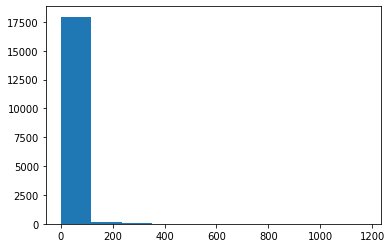

In [400]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G)

In [314]:
# THIS TAKES A LOOOOOONG TIME TO RUN!!!!!! 
# EVEN WITH HALF THE NODES IT TAKES A WHILE!!!

# degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())

# fig, ax = plt.subplots()
# plt.bar(deg, cnt, width=0.80, color="b")

# plt.title("Degree Histogram")
# plt.ylabel("Count")
# plt.xlabel("Degree")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

# # draw graph in inset
# plt.axes([0.4, 0.4, 0.5, 0.5])
# Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(G)
# plt.axis("off")
# nx.draw_networkx_nodes(G, pos, node_size=20)
# nx.draw_networkx_edges(G, pos, alpha=0.4)
# plt.show()

## Node centralities - find the top 10 people for each case

#### find people who could be the fastest to reach all other people. DEGREE CENTRALITY

In [401]:
DC = nx.degree_centrality(G)
sorted(DC.items(), reverse=True)[:10]

[('zulie.flores', 0.0015991177281499862),
 ('zimin.lu', 0.0012682657843948167),
 ('zhiyun.yang', 0.00016542597187758478),
 ('zhiyong.wei', 0.0006617038875103391),
 ('zelda.paschal', 0.00011028398125172319),
 ('zarin.imam', 0.00011028398125172319),
 ('zakiyyah.mcclure', 0.0011579818031430935),
 ('zachary.mccarroll', 0.00022056796250344637),
 ('ywang', 5.5141990625861594e-05),
 ('yvonne.acosta', 5.5141990625861594e-05)]

#### find the most important people, most information goes through them. BETWEENESS CENTRALITY

In [335]:
# total of 18136 nodes
# k means number of nodes to consider, anything above 1000 nodes takes too long...
BC = nx.betweenness_centrality(G, k = 100)
sorted(BC.items(), reverse=True)[:10]

[('zulie.flores', 0.00012101030589723896),
 ('zimin.lu', 0.0002745344988666076),
 ('zhiyun.yang', 8.038542998708231e-08),
 ('zhiyong.wei', 7.665444383427416e-05),
 ('zelda.paschal', 8.145437445276353e-07),
 ('zarin.imam', 0.0),
 ('zakiyyah.mcclure', 2.2722867492755083e-05),
 ('zachary.mccarroll', 0.00019180229097327665),
 ('ywang', 0.0),
 ('yvonne.acosta', 0.0)]

#### find people who are best connected with well connected people

In [338]:
EC = nx.eigenvector_centrality(G)

In [339]:
sorted(EC.items(), reverse=True)[:10]

[('zulie.flores', 0.0025925338541224956),
 ('zimin.lu', 0.004474195282103696),
 ('zhiyun.yang', 0.0006565044904122348),
 ('zhiyong.wei', 0.0056448946939806404),
 ('zelda.paschal', 7.3371510936615355e-06),
 ('zarin.imam', 0.0002854784056241719),
 ('zakiyyah.mcclure', 0.002693193616931011),
 ('zachary.mccarroll', 0.0004576370273257734),
 ('ywang', 1.5585895822045918e-05),
 ('yvonne.acosta', 5.594456246e-05)]


## Communities

#### Cluster the users to different communities using function `k_clique_communities`

In [402]:
from networkx.algorithms.community import k_clique_communities

In [403]:
#K5 = nx.convert_node_labels_to_integers(G)
#G.add_edges_from(K5.edges())

In [409]:
# k is the size of smallest clique
# AND will return empty list if value is greater than ~10
kcc = list(k_clique_communities(G, 9))

In [410]:
len(kcc)

2

In [411]:
kcc

[frozenset({' james.steffes',
            ' jeff.dasovich',
            ' john.lavorato',
            ' tim.belden',
            'james.steffes',
            'jeff.dasovich',
            'mary.hain',
            'richard.sanders',
            'sarah.novosel',
            'steven.kean',
            'susan.mara',
            'tim.belden'}),
 frozenset({' samantha.boyd',
            'carol.clair',
            'edward.sacks',
            'mark.taylor',
            'mary.cook',
            'sara.shackleton',
            'stephanie.panus',
            'susan.bailey',
            'tana.jones',
            'tanya.rohauer'})]

#### Compute clustering coefficients for each node - low clustering coefficients are in places, where network usually falls apart

In [ ]:
# Clustering coefficient is a property of a node in a network. 
# it tells how well connected the neighborhood of the node is. 
# If the neighborhood is fully connected, coef => 1
# If hardly any connections are in the neighborhood, coef => 0

In [413]:
CC = nx.clustering(G)

In [415]:
# total = 18136 nodes
sorted(CC.items())[:20]

[(' #2.martin', 0),
 (' #23.training', 0),
 (' #24.training', 0),
 (' #25.training', 0),
 (' #26.training', 0),
 (' #28.training', 0),
 (' #29.training', 0),
 (' #30.training', 0),
 (" '", 0),
 (" '.'delaney", 0),
 (" '/o=enron/ou=na/cn=recipients/cn=notesaddr/cn=a478079f-55e1f3b0-862566fa-612229'",
  0),
 (" 'bowers", 0),
 (" 'lewis", 0),
 (" 'rmservices'", 0),
 (" 'todd'.delahoussaye", 1.0),
 (' /o=enron/ou=na/cn=recipients/cn=notesaddr/cn=41bc9f29-eb12503a-86256603-4d8b0e',
  0),
 (' /o=enron/ou=na/cn=recipients/cn=notesaddr/cn=8b350b76-1ddd01ec-86256655-47240f',
  0),
 (' /o=enron/ou=na/cn=recipients/cn=notesaddr/cn=90cf0ed1-27e2e701-862564b3-6b8593',
  0),
 (' /o=enron/ou=na/cn=recipients/cn=notesaddr/cn=a3a4cb81-65db1a4f-862569e7-6cfe2f',
  0),
 (' /o=enron/ou=na/cn=recipients/cn=notesaddr/cn=a478079f-55e1f3b0-862566fa-612229',
  0)]

## (Stretch) 
### Visualizations

#### visualize the network
it might be slow on our computers with all nodes. Feel free to play around with the graph using the smaller sample of the nodes

In [423]:
# converts node names to integers
H = nx.convert_node_labels_to_integers(G)

In [426]:
all_nodes = list(H.nodes)
#all_nodes[:100]

In [442]:
# too many nodes
# taking subset of nodes (nodes = 1000,2000,3000 all look roughly the same)
sub_H = H.subgraph(all_nodes[:3000])

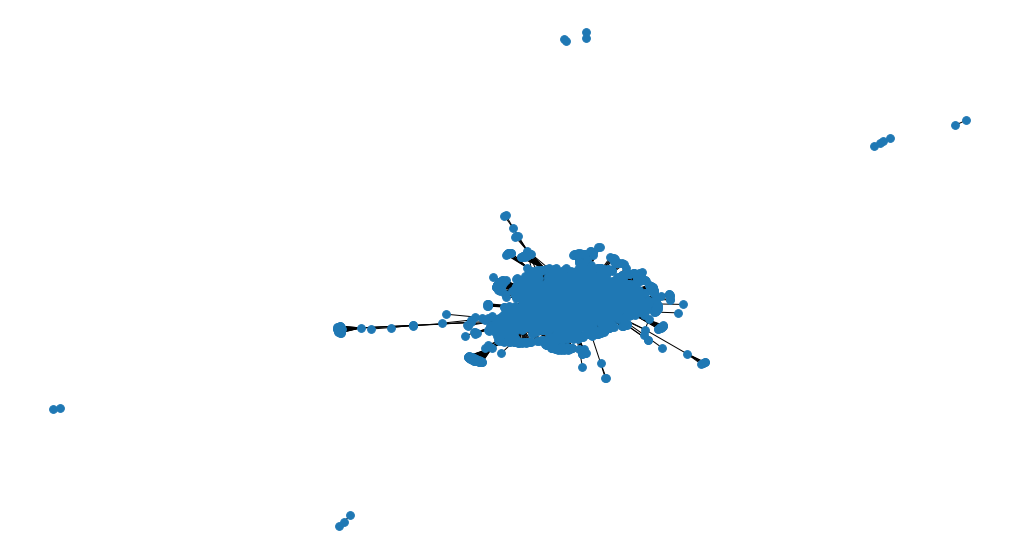

In [443]:
fig, ax = plt.subplots(figsize=(18,10))
nx.draw(sub_H, node_size=60, ax = ax)